In [1]:

# used libraries 
import json
import pandas as pd
import matplotlib.pyplot as plt

# Similar Player Component used libraries 
from sklearn.metrics.pairwise import cosine_similarity # Cosine Similarity
from sklearn.cluster import KMeans # Kmeans clustering

# evaluation
from sklearn.metrics import silhouette_score
from scipy.stats import spearmanr
from scipy.stats import kendalltau

# Scouter AI Component used libraries
import os 
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import AIMessage, HumanMessage, SystemMessage

# evaluation
from rouge_score import rouge_scorer
from bert_score import score
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from mplsoccer import Radar, FontManager, grid
import matplotlib.pyplot as plt

### Simple cosine similarity between players

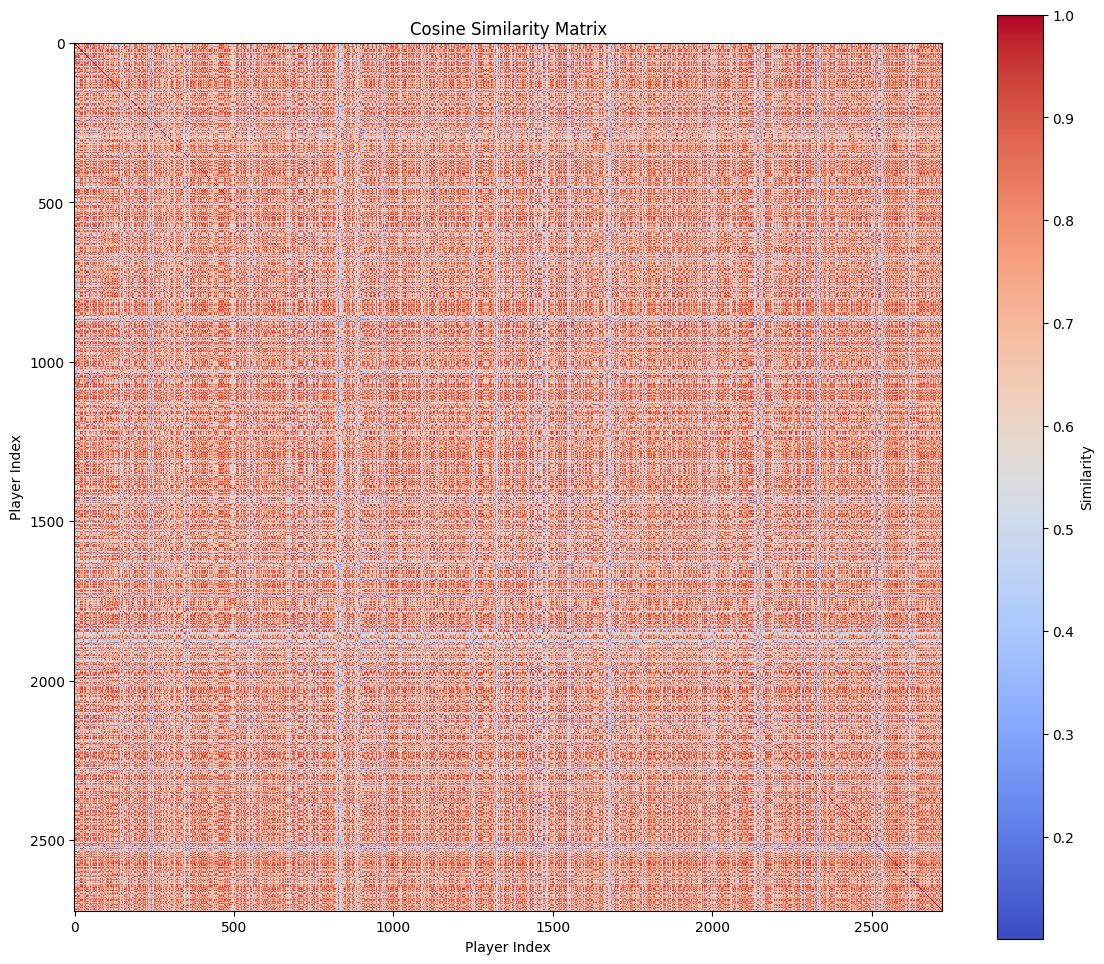

In [2]:
df = pd.read_csv("data_player/football-player-stats-2023.csv")

df_player_norm = df.copy()
custom_mapping = {
    'GK': 1,
    'DF,FW': 4,
    'MF,FW': 8,
    'DF': 2,
    'DF,MF': 3,
    'MF,DF': 5,
    'MF': 6,
    'FW,DF': 7,
    'FW,MF': 9,
    'FW': 10
}

# Apply custom mapping to the 'Pos' column
df_player_norm['Pos'] = df_player_norm['Pos'].map(custom_mapping)

selected_features = ['Pos', 'Age','Playing Time MP', 'Performance Gls', 'Performance Ast',
       'Performance G+A', 'Performance G-PK', 'Performance Fls',
       'Performance Fld', 'Performance Crs', 'Performance Recov',
       'Expected xG', 'Expected npxG', 'Expected xAG', 'Expected xA',
       'Expected A-xAG', 'Expected G-xG', 'Expected np:G-xG',
       'Progression PrgC', 'Progression PrgP', 'Progression PrgR',
       'Tackles Tkl', 'Tackles TklW', 'Tackles Def 3rd', 'Tackles Mid 3rd',
       'Tackles Att 3rd', 'Challenges Att', 'Challenges Tkl%',
       'Challenges Lost', 'Blocks Blocks', 'Blocks Sh', 'Blocks Pass', 'Int',
       'Clr', 'Standard Sh', 'Standard SoT', 'Standard SoT%', 'Standard Sh/90',
       'Standard Dist', 'Standard FK', 'Performance GA', 'Performance SoTA',
       'Performance Saves', 'Performance Save%', 'Performance CS',
       'Performance CS%', 'Penalty Kicks PKatt', 'Penalty Kicks Save%',
       'SCA SCA', 'GCA GCA', 'Aerial Duels Won', 'Aerial Duels Lost',
       'Aerial Duels Won%', 'Total Cmp', 'Total Att', 'Total Cmp%',
       'Total TotDist', 'Total PrgDist', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP']

# Apply MinMaxScaler normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_player_norm[selected_features] = scaler.fit_transform(df_player_norm[selected_features])
similarity = cosine_similarity(df_player_norm[selected_features])

# Plot Cosine Similarity Matrix
plt.figure(figsize=(14, 12))
plt.imshow(similarity, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Similarity')
plt.title('Cosine Similarity Matrix')
plt.xlabel('Player Index')
plt.ylabel('Player Index')
plt.show()

### Function to find the similar playerers using only cosine simialarity

In [3]:
def find_similar_player(i,similarity):
    similarity_score = list(enumerate(similarity[i]))
    similar_players = sorted(similarity_score, key=lambda x:x[1], reverse=True)
    # Creating a list to store the data of similar players
    similar_players_data = []

    # Cycle to extract information from similar players
    for player in similar_players[1:11]:
        index = player[0]
        player_records = df[df['Rk'] == index]
        if not player_records.empty:
            player_data = player_records.iloc[0] 
            similar_players_data.append(player_data)

    # Creating a DataFrame from the data of similar players
    similar_players_df = pd.DataFrame(similar_players_data)

    return similar_players_df

In [4]:
a = find_similar_player(0,similarity)
a

Rk                 Player Nation    Pos           Squad  \
2017  2017          Gonzalo Plata    ECU     FW      Valladolid   
727    727             Ritsu Doan    JPN  MF,FW        Freiburg   
1160  1160           Adrien Hunou    FRA  MF,FW          Angers   
1475  1475         Sean Longstaff    ENG     MF   Newcastle Utd   
1644  1644            John McGinn    SCO  MF,FW     Aston Villa   
1274  1274         Jakub Kamiński    POL  FW,DF       Wolfsburg   
1915  1915  Isaac Palazón Camacho    ESP  FW,MF  Rayo Vallecano   
2077  2077           Jacob Ramsey    ENG  MF,FW     Aston Villa   
492    492           Fares Chaïbi    ALG  FW,MF        Toulouse   
2643  2643            Joe Willock    ENG     MF   Newcastle Utd   

                Comp  Age  Born  Playing Time MP  Performance Gls  ...  \
2017         La Liga   23  2000               34                1  ...   
727       Bundesliga   25  1998               33                5  ...   
1160         Ligue 1   29  1994               34                4  ...   
1475  Premier League   26  1997               33                1  ...   
1644  Premier League   29  1994               34                1  ...   
1274      Bundesliga   21  2002               31                4  ...   
1915         La Liga   29  1994               37                9  ...   
2077  Premier League   22  2001               35                6  ...   
492          Ligue 1   21  2002               36                5  ...   
2643  Premier League   24  1999               35                3  ...   

      Total Cmp  Total Att  Total Cmp%  Total TotDist  Total PrgDist  KP  1/3  \
2017        582        782        74.4           7367           1681  37   28   
727         437        625        69.9           6572           1840  27   44   
1160        572        753        76.0           8441           2005  18   38   
1475        943       1163        81.1          15457           4299  23   80   
1644        805       1028        78.3          14385           4830  18  114   
1274        495        667        74.2           7398           2278  28   30   
1915        979       1376        71.1          16672           4781  66   84   
2077        728        889        81.9          10240           2665  42   67   
492         742       1018        72.9          11489           3144  30   68   
2643        777        951        81.7          12123           3082  39   91   

      PPA  CrsPA  PrgP  
2017   19      3    54  
727    28      5    69  
1160   12      1    62  
1475   21      5   116  
1644   20      5   140  
1274   39      5    78  
1915   47     11   127  
2077   28      4    98  
492    27      5   101  
2643   34      8   121  

[10 rows x 69 columns]

### Finding the number of clusters

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

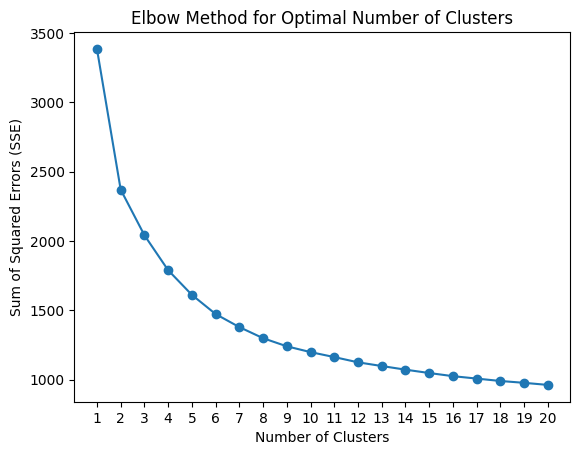

In [5]:
# Calculation of SSE (inertia) for different cluster values
sse_values = []
possible_clusters = range(1, 21)  # test with range of 20 clusters

for num_clusters in possible_clusters:
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_model.fit(df_player_norm[selected_features])
    sse_values.append(kmeans_model.inertia_)

# Visualisation of SSE trend
plt.plot(possible_clusters, sse_values, marker='o')
plt.xticks(possible_clusters, possible_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

### 4 is the total number of clusters, therefore, we have the final clustered dataset

In [6]:
# Specifies the desired number of clusters
num_clusters = 4

# Create an instance of the K-Means model
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)

# Train the model on player features
kmeans_model.fit(df_player_norm[selected_features])

# Get the cluster labels assigned to players
cluster_labels = kmeans_model.labels_

# Add cluster labels to the player dataframe
df_player_norm['Cluster'] = cluster_labels
df['Cluster'] = cluster_labels

/Users/asheshlalshrestha/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
from sklearn.metrics import silhouette_score
print(f'Silhouette Score(n=4): {silhouette_score(df_player_norm[selected_features], cluster_labels)}')

Silhouette Score(n=4): 0.274574188555236


### function to find 10 similar players using cosine similarity and the custered data
1. This function will initially find the clusters 
2. Then it will creat a cosine similarity matrix between the players of the respective clusters
3. Finally it will then give us the top ten most similar players

In [8]:
def find_similar_players(i,df):  
    # # Filter the dataframe for players in the same cluster as the target player
    df_player_norm = df.copy()
    custom_mapping = {
        'GK': 1,
        'DF,FW': 4,
        'MF,FW': 8,
        'DF': 2,
        'DF,MF': 3,
        'MF,DF': 5,
        'MF': 6,
        'FW,DF': 7,
        'FW,MF': 9,
        'FW': 10
    }

# Apply custom mapping to the 'Pos' column
    df_player_norm['Pos'] = df_player_norm['Pos'].map(custom_mapping)

    selected_features = ['Pos', 'Age','Playing Time MP', 'Performance Gls', 'Performance Ast',
           'Performance G+A', 'Performance G-PK', 'Performance Fls',
           'Performance Fld', 'Performance Crs', 'Performance Recov',
           'Expected xG', 'Expected npxG', 'Expected xAG', 'Expected xA',
           'Expected A-xAG', 'Expected G-xG', 'Expected np:G-xG',
           'Progression PrgC', 'Progression PrgP', 'Progression PrgR',
           'Tackles Tkl', 'Tackles TklW', 'Tackles Def 3rd', 'Tackles Mid 3rd',
           'Tackles Att 3rd', 'Challenges Att', 'Challenges Tkl%',
           'Challenges Lost', 'Blocks Blocks', 'Blocks Sh', 'Blocks Pass', 'Int',
           'Clr', 'Standard Sh', 'Standard SoT', 'Standard SoT%', 'Standard Sh/90',
           'Standard Dist', 'Standard FK', 'Performance GA', 'Performance SoTA',
           'Performance Saves', 'Performance Save%', 'Performance CS',
           'Performance CS%', 'Penalty Kicks PKatt', 'Penalty Kicks Save%',
           'SCA SCA', 'GCA GCA', 'Aerial Duels Won', 'Aerial Duels Lost',
           'Aerial Duels Won%', 'Total Cmp', 'Total Att', 'Total Cmp%',
           'Total TotDist', 'Total PrgDist', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP']

    scaler = MinMaxScaler()
    df_player_norm[selected_features] = scaler.fit_transform(df_player_norm[selected_features])
    df_player_norm['Cluster']=df['Cluster']
    # Select the player of interest (target)
    target_player = df_player_norm[df_player_norm['Rk'] == i]
    target_features = target_player[selected_features]
    target_cluster = target_player['Cluster'].iloc[0]  # Get the cluster label of the target player
    
    similar_players_cluster_df = df_player_norm[df_player_norm['Cluster'] == target_cluster].copy()
    # # Calculate cosine similarity between the target player and other players in the same cluster
    similarities = cosine_similarity(target_features, similar_players_cluster_df[selected_features])
    similarities = similarities[0] * 100
    # # Add the 'Similarity' column to the dataframe using .loc
    similar_players_cluster_df.loc[:, 'Similarity'] = similarities

    # # Sort the DataFrame based on the 'Similarity' column in descending order
    similar_players_cluster_df = similar_players_cluster_df.sort_values(by='Similarity', ascending=False)

    # # Select from the second to the 11th element (remembering that indexing starts from 0)
    similar_players_cluster_df = similar_players_cluster_df.iloc[1:11]


    # # Retrieve the non-normalized data from the original dataframe
    similar_players_cluster_df = df[df['Rk'].isin(similar_players_cluster_df['Rk'])]

    return similar_players_cluster_df

In [9]:
a = find_similar_players(4,df)

In [10]:
a

Rk                   Player Nation    Pos       Squad            Comp  \
96      96             Ethan Ampadu    WAL  DF,MF      Spezia         Serie A   
110    110           Waldemar Anton    GER     DF   Stuttgart      Bundesliga   
618    618                    Dante    BRA     DF        Nice         Ligue 1   
720    720          Alexander Djiku    GHA     DF  Strasbourg         Ligue 1   
1268  1268            Pierre Kalulu    FRA     DF       Milan         Serie A   
1598  1598    Lucas Martínez Quarta    ARG     DF  Fiorentina         Serie A   
1621  1621  Konstantinos Mavropanos    GRE     DF   Stuttgart      Bundesliga   
2157  2157          Cristian Romero    ARG     DF   Tottenham  Premier League   
2215  2215            Yoann Salmier    GUF     DF      Troyes         Ligue 1   
2479  2479             Rafael Tolói    ITA     DF    Atalanta         Serie A   

      Age  Born  Playing Time MP  Performance Gls  ...  Total Att  Total Cmp%  \
96     23  2000               31                0  ...       1548        81.0   
110    27  1996               34                1  ...       2059        79.1   
618    40  1983               37                1  ...       2643        89.9   
720    29  1994               31                1  ...       1507        80.6   
1268   23  2000               34                1  ...       1821        87.3   
1598   27  1996               27                1  ...       1524        81.7   
1621   26  1997               28                2  ...       1512        83.0   
2157   25  1998               27                0  ...       1606        87.6   
2215   31  1992               32                1  ...       1456        82.3   
2479   33  1990               32                2  ...       1682        80.3   

      Total TotDist  Total PrgDist  KP  1/3  PPA  CrsPA  PrgP  Cluster  
96            23855           9527  13  106   14      4   125        1  
110           32013          12155  10  112   16      4   135        1  
618           45941          18236  12  154    9      0   160        1  
720           25533          10650  11  117   13      4   136        1  
1268          29265           9921  10  109   10      5   138        1  
1598          27128          10926   8  119    5      1   119        1  
1621          27727           9978  15   92   12      2   120        1  
2157          25378           9085   8   87    8      0    92        1  
2215          21721           8653   5  108    1      0   121        1  
2479          24720           9204  17  126   15      2   148        1  

[10 rows x 70 columns]

In [11]:
# a.to_csv("player_test.csv")

In [12]:
df['Total PrgDist'].min()

0

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def find_similar_players(i, df):
    # Define a custom mapping for 'Pos' column
    custom_mapping = {
        'GK': 1,
        'DF,FW': 4,
        'MF,FW': 8,
        'DF': 2,
        'DF,MF': 3,
        'MF,DF': 5,
        'MF': 6,
        'FW,DF': 7,
        'FW,MF': 9,
        'FW': 10
    }

    # Apply custom mapping to the 'Pos' column
    df_player_norm = df.copy()
    df_player_norm['Pos'] = df_player_norm['Pos'].map(custom_mapping)

    # Define selected features for normalization
    selected_features = ['Pos', 'Age', 'Playing Time MP', 'Performance Gls', 'Performance Ast',
                         'Performance G+A', 'Performance G-PK', 'Performance Fls',
                         'Performance Fld', 'Performance Crs', 'Performance Recov',
                         'Expected xG', 'Expected npxG', 'Expected xAG', 'Expected xA',
                         'Expected A-xAG', 'Expected G-xG', 'Expected np:G-xG',
                         'Progression PrgC', 'Progression PrgP', 'Progression PrgR',
                         'Tackles Tkl', 'Tackles TklW', 'Tackles Def 3rd', 'Tackles Mid 3rd',
                         'Tackles Att 3rd', 'Challenges Att', 'Challenges Tkl%',
                         'Challenges Lost', 'Blocks Blocks', 'Blocks Sh', 'Blocks Pass', 'Int',
                         'Clr', 'Standard Sh', 'Standard SoT', 'Standard SoT%', 'Standard Sh/90',
                         'Standard Dist', 'Standard FK', 'Performance GA', 'Performance SoTA',
                         'Performance Saves', 'Performance Save%', 'Performance CS',
                         'Performance CS%', 'Penalty Kicks PKatt', 'Penalty Kicks Save%',
                         'SCA SCA', 'GCA GCA', 'Aerial Duels Won', 'Aerial Duels Lost',
                         'Aerial Duels Won%', 'Total Cmp', 'Total Att', 'Total Cmp%',
                         'Total TotDist', 'Total PrgDist', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP']

    # Normalize the features
    scaler = MinMaxScaler()
    df_player_norm[selected_features] = scaler.fit_transform(df_player_norm[selected_features])
    df_player_norm['Cluster'] = df['Cluster']

    # Select the player of interest (target)
    target_player = df_player_norm[df_player_norm['Rk'] == i]
    target_features = target_player[selected_features]
    target_cluster = target_player['Cluster'].iloc[0]

    # Filter the dataframe for players in the same cluster as the target player
    similar_players_cluster_df = df_player_norm[df_player_norm['Cluster'] == target_cluster].copy()

    # Calculate cosine similarity between the target player and other players in the same cluster
    similarities = cosine_similarity(target_features, similar_players_cluster_df[selected_features])
    similarities = similarities[0] * 100

    # Add the 'Similarity' column to the dataframe
    similar_players_cluster_df.loc[:, 'Similarity'] = similarities

    # Sort the dataframe based on the 'Similarity' column in descending order
    similar_players_cluster_df = similar_players_cluster_df.sort_values(by='Similarity', ascending=False)

    # Select the top 10 most similar players (excluding the target player)
    similar_players_cluster_df = similar_players_cluster_df.iloc[0:11]

    # Retrieve the non-normalized data from the original dataframe
    similar_players_cluster_df = df[df['Rk'].isin(similar_players_cluster_df['Rk'])]
    
    player_row = similar_players_cluster_df[similar_players_cluster_df['Rk'] == i]['Pos'].iloc[0]

    # Check the player's position and define radar chart parameters accordingly
    if player_row in ['FW', 'MF,FW', 'FW,MF']:
        # Define parameters for the radar chart for Forwards
        params = [
            'Expected xG', 'Standard Sh', 'Standard SoT%',
            'Standard Sh/90', 'Aerial Duels Won%', 'Total Att',
            'Total TotDist', 'Total PrgDist'
        ]
    elif player_row in ['DF', 'DF,FW', 'DF,MF', 'FW,DF']:
        # Define parameters for the radar chart for Defenders
        params = [
            'Expected xG', 'Tackles Tkl', 'Tackles TklW',
            'Tackles Def 3rd', 'Tackles Mid 3rd', 'Challenges Tkl%',
            'Blocks Blocks', 'Blocks Pass'
        ]
    elif player_row == 'GK':
        # Define parameters for the radar chart for Goalkeepers
        params = [
            "Performance GA", "Performance SoTA", "Performance Saves",
            "Performance Save%", "Performance CS", "Performance CS%",
            "Penalty Kicks PKatt", "Penalty Kicks Save%"
        ]
    elif player_row in ['MF', 'MF,DF']:
        # Define default parameters or handle cases not covered
        params = [
            'Expected xA', 'Progression PrgC', 'K/P', '1/3', 'PPA',
            'CrsPA', 'Total Cmp%', 'Total TotDist'
        ]
    else:
        # Handle other cases or define default parameters
        params = []
    similar_players_cluster_df = similar_players_cluster_df.iloc[1:]
    low = []
    high = []

    # Determine the min and max values for each parameter
    for param in params:
        low.append(similar_players_cluster_df[param].min())
        high.append(similar_players_cluster_df[param].max())

    # Create a Radar object
    radar = Radar(params, low, high,
                  round_int=[False] * len(params),
                  num_rings=4,
                  ring_width=0.5, center_circle_radius=0.5)

    # Generate radar charts for the similar players
    for j in range(len(similar_players_cluster_df)):
        player_name = similar_players_cluster_df.iloc[j]['Player']
        player_val = similar_players_cluster_df.iloc[j][params].values
        fig, ax = radar.setup_axis()  # format axis as a radar
        rings_inner = radar.draw_circles(ax=ax, facecolor='#ffb2b2', edgecolor='#fc5f5f')  # draw circles
        radar_output = radar.draw_radar(player_val, ax=ax,
                                        kwargs_radar={'facecolor': '#aa65b2'},
                                        kwargs_rings={'facecolor': '#66d8ba'})  # draw the radar
        radar_poly, rings_outer, vertices = radar_output
        range_labels = radar.draw_range_labels(ax=ax, fontsize=15)  # draw the range labels
        param_labels = radar.draw_param_labels(ax=ax, fontsize=15)  # draw the param labels
        title = ax.set_title(f'Radar Chart for {player_name}', fontsize=20)
        title.set_position([0.5, 1.05])  # Adjust the position (x, y) relative to the axes (0-1)

        # Show the radar chart
        plt.show()  # Show the figure
        plt.close()  # Close the current figure to release memory


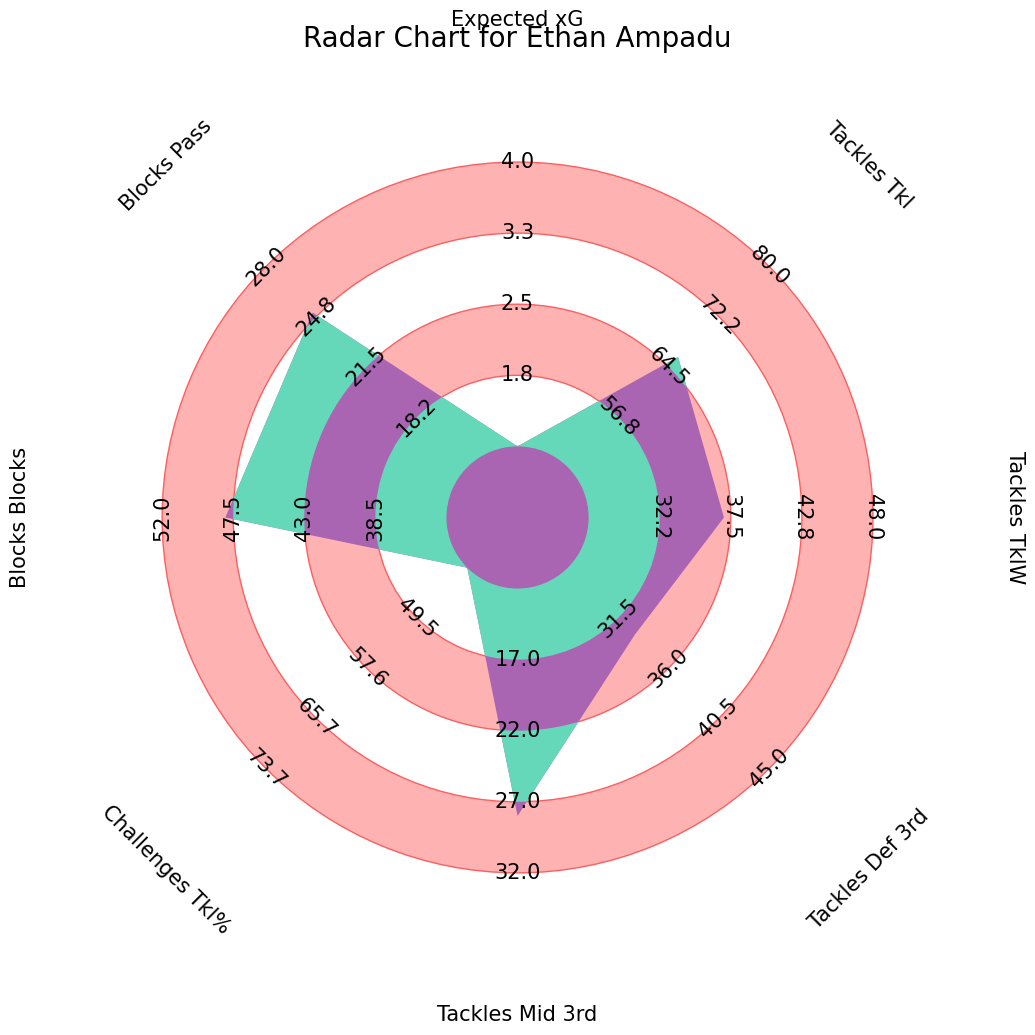

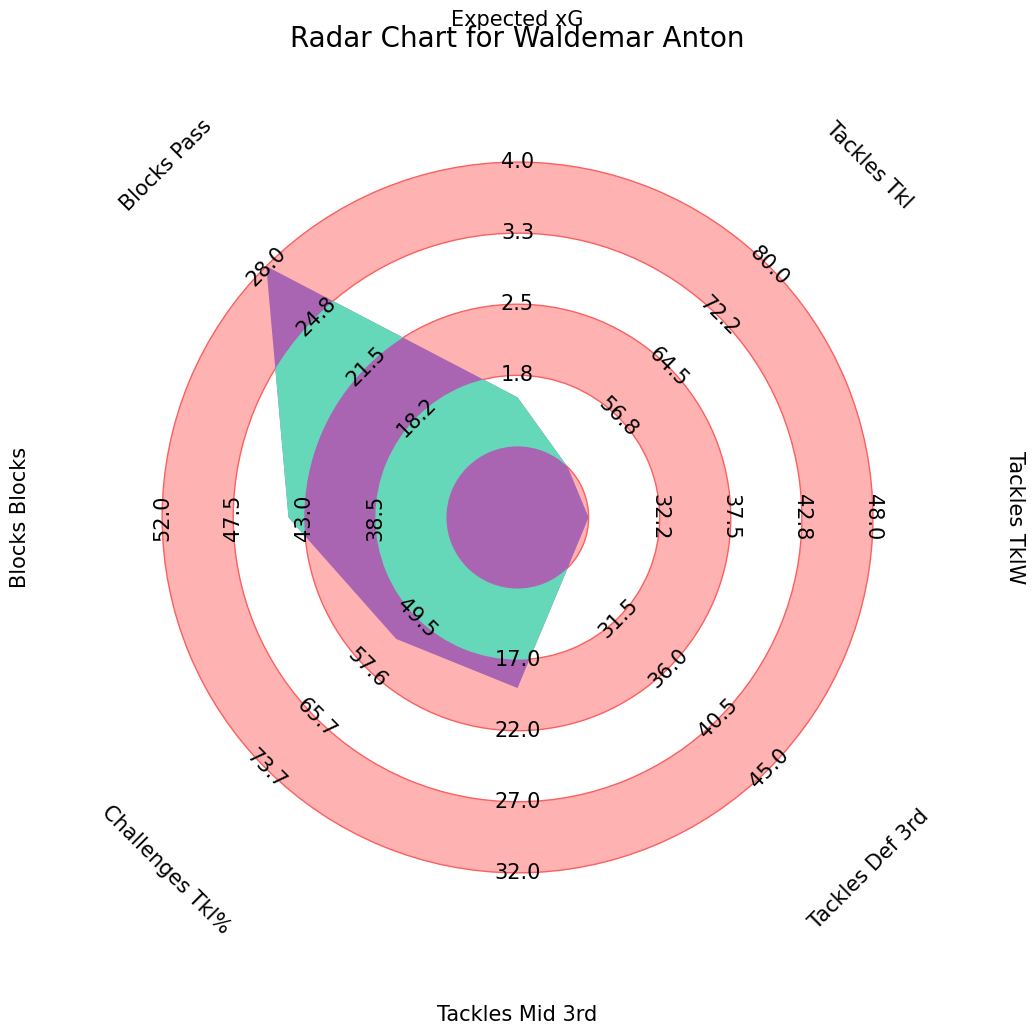

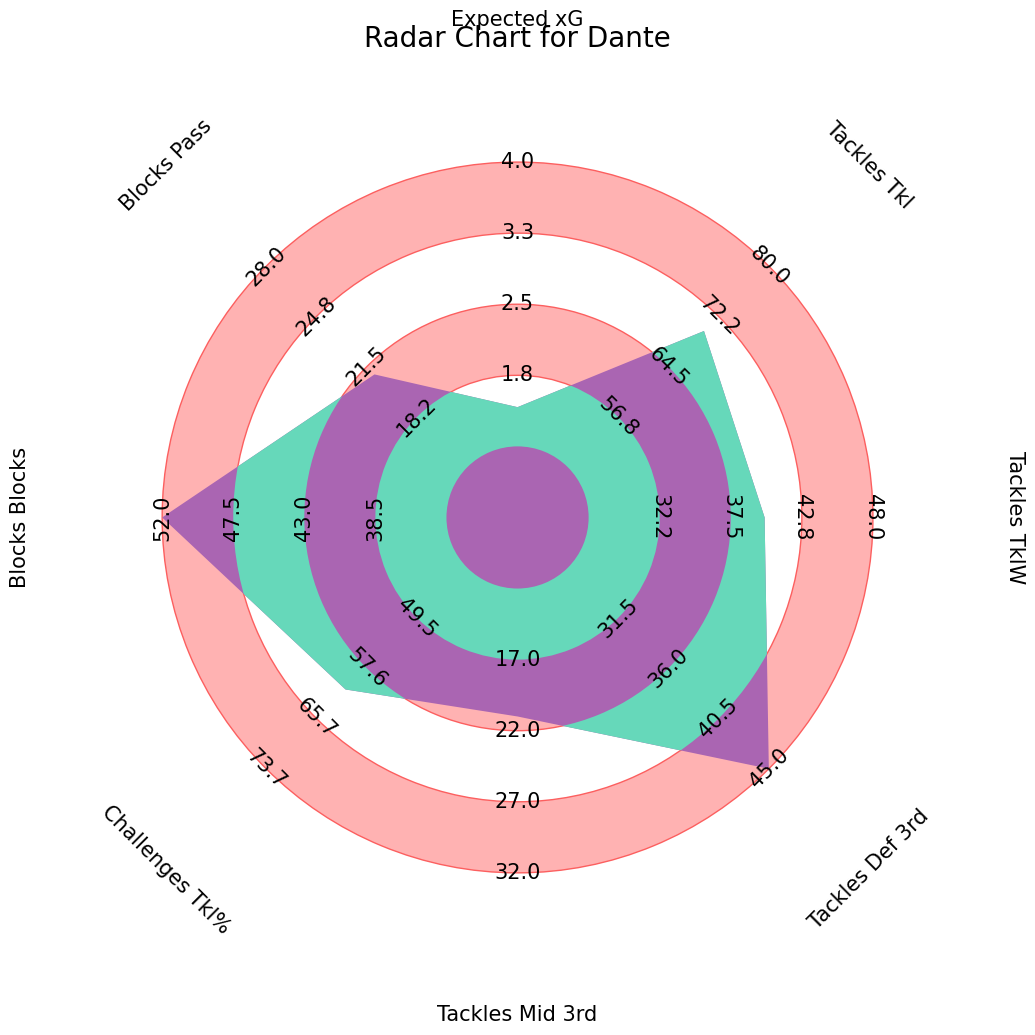

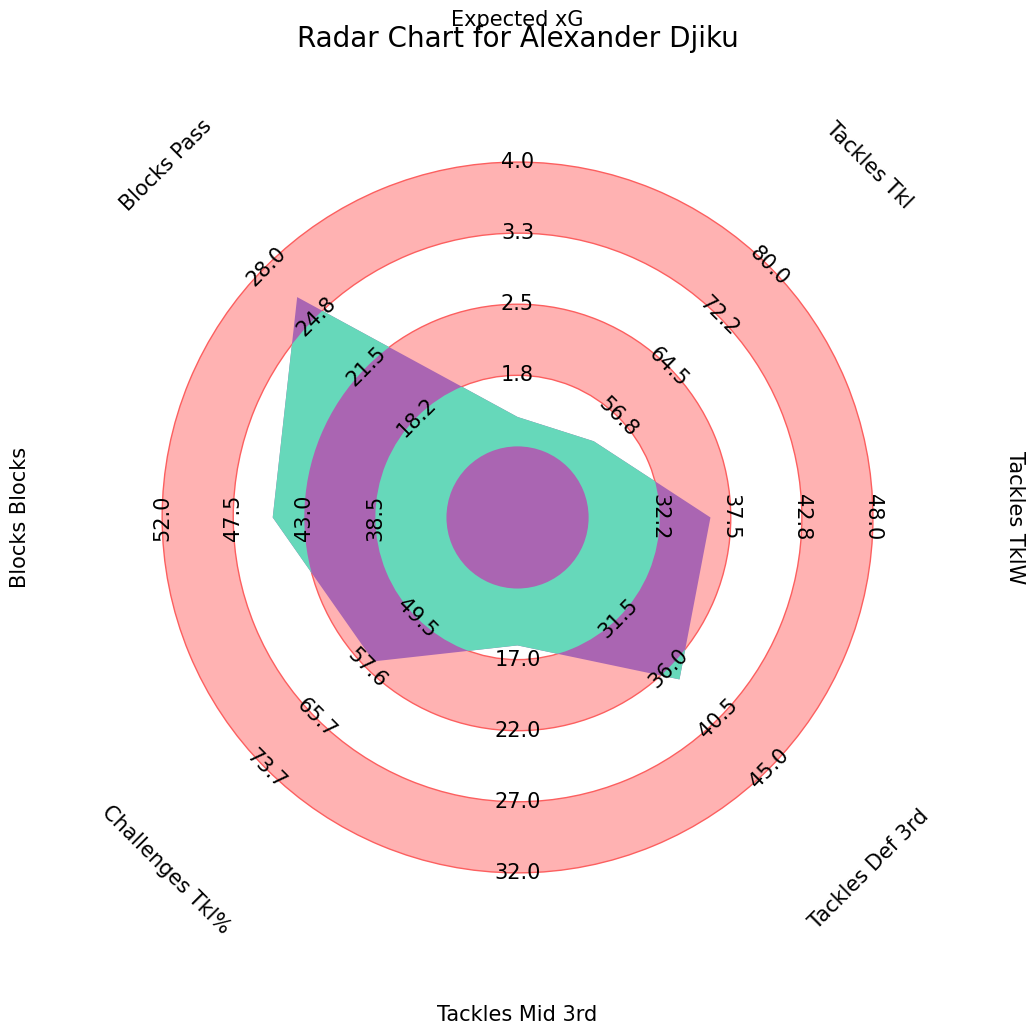

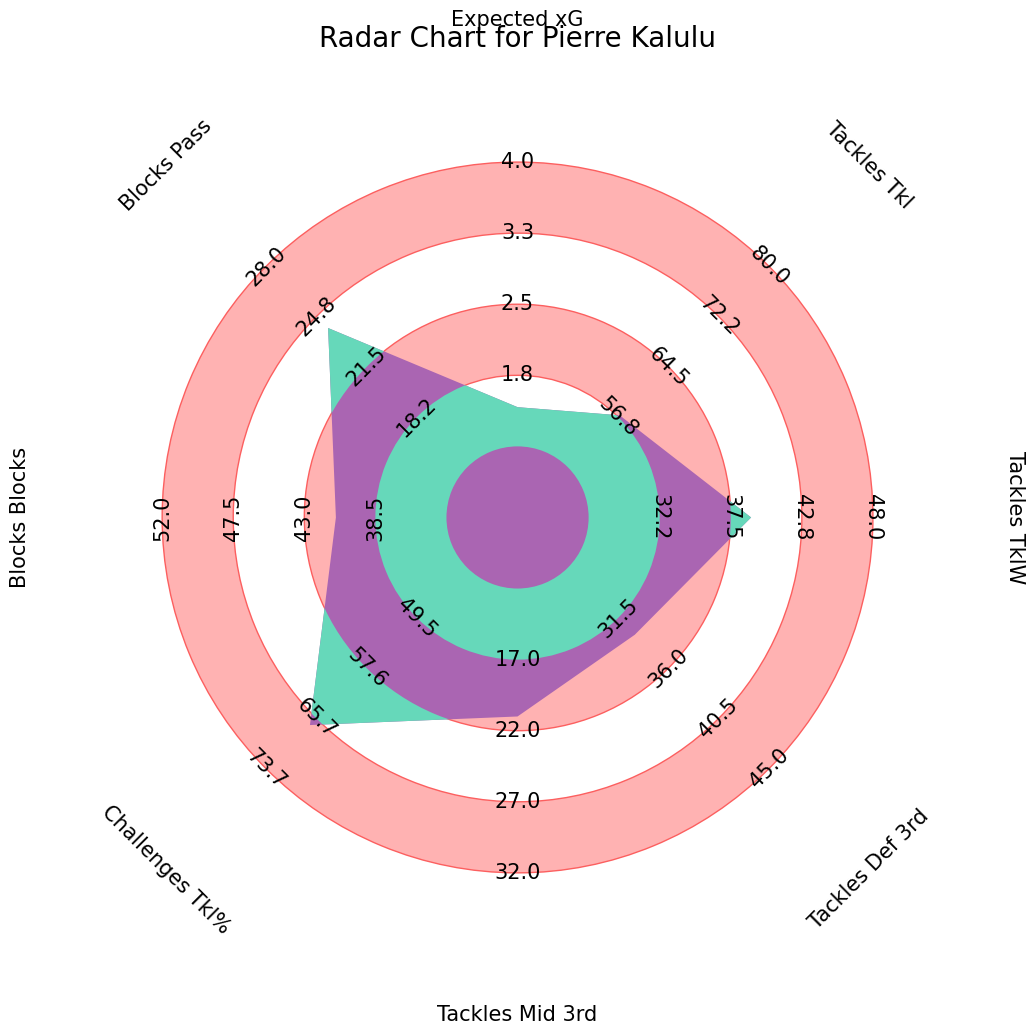

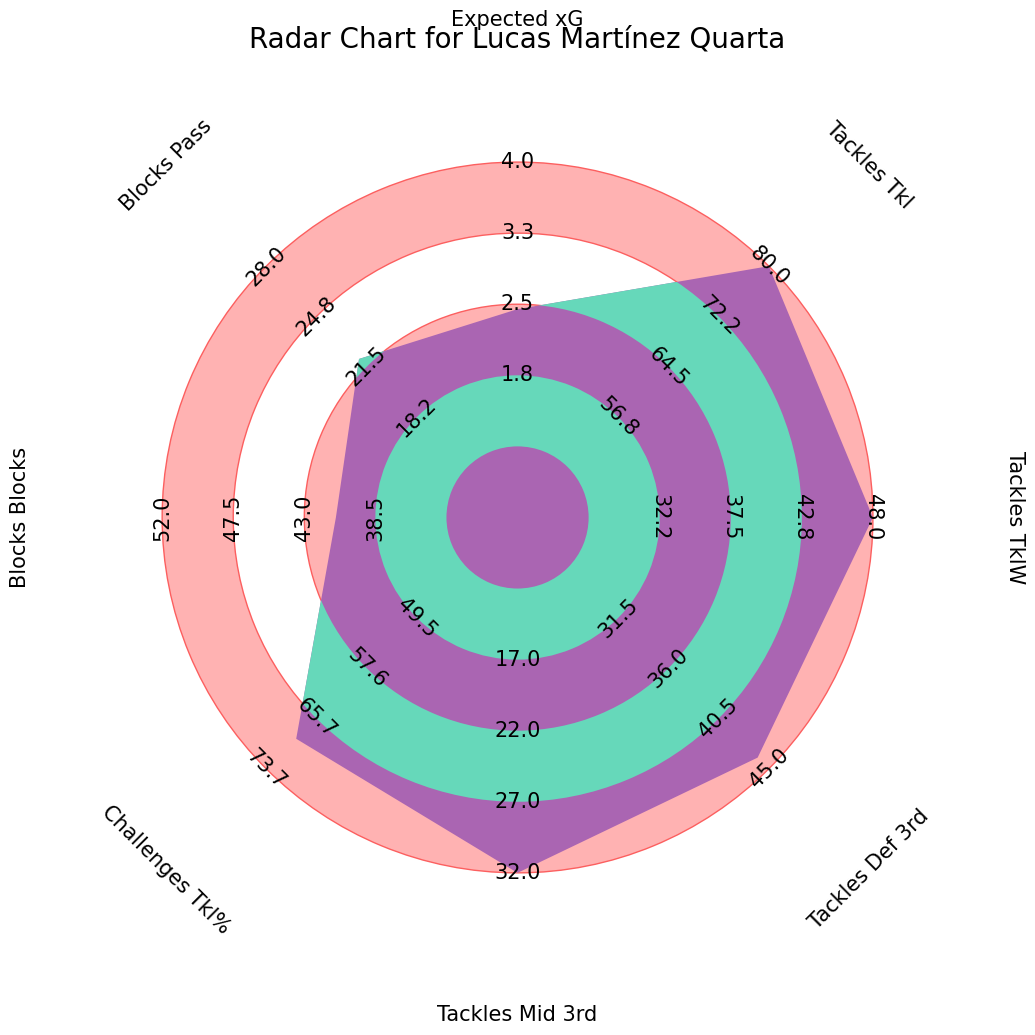

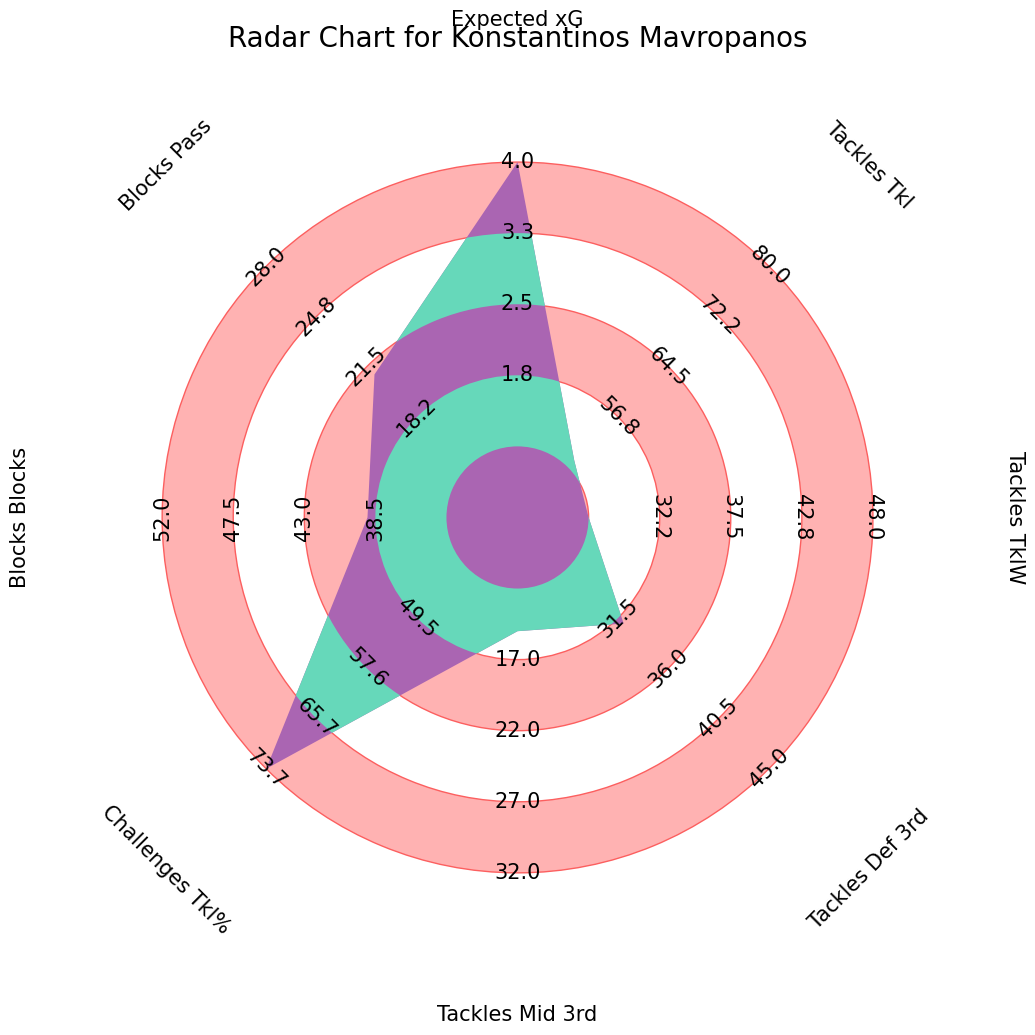

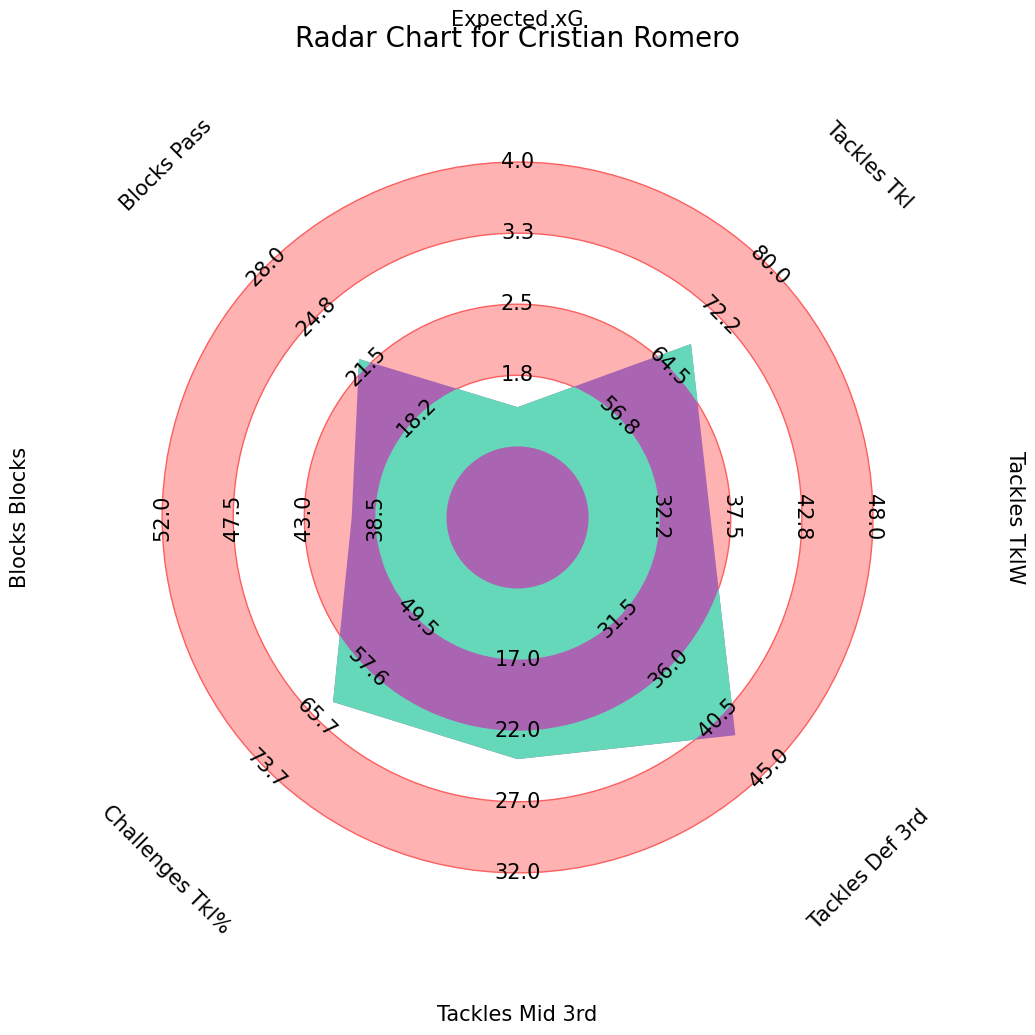

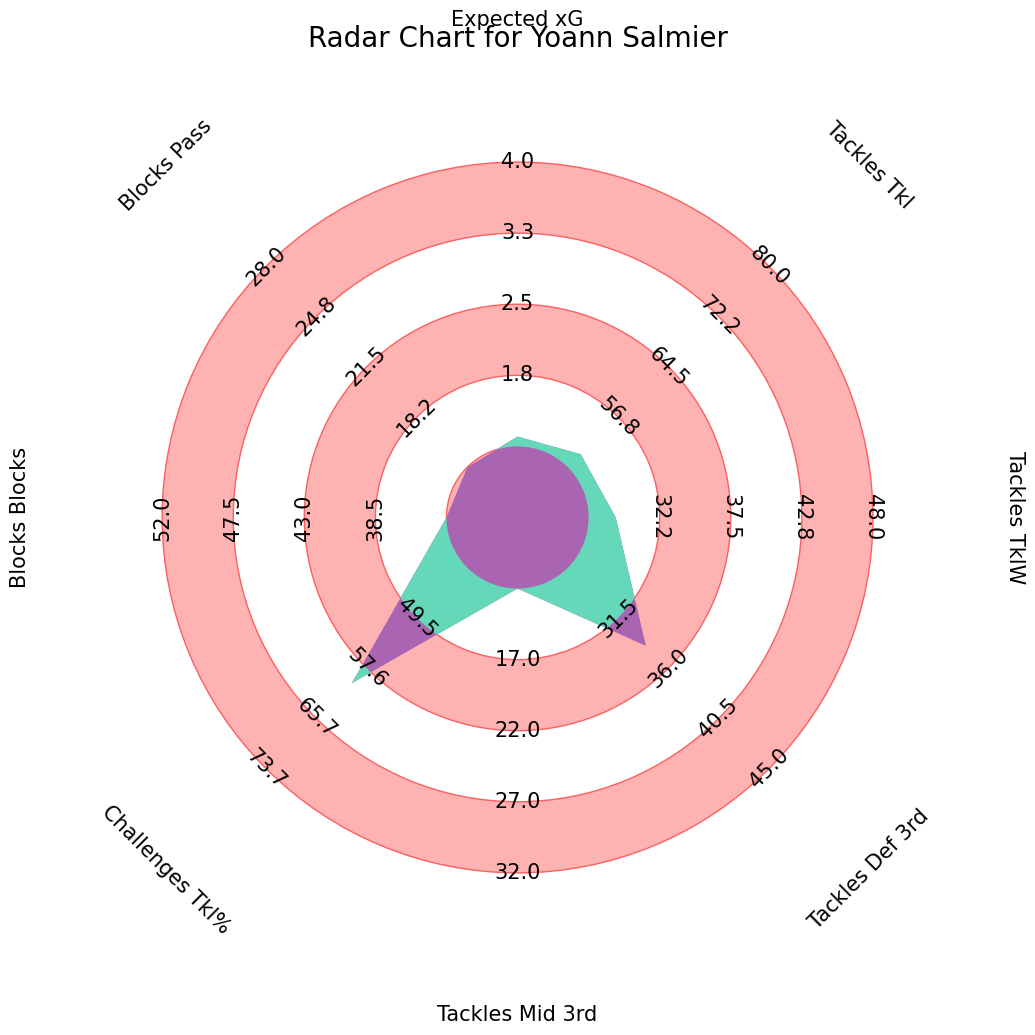

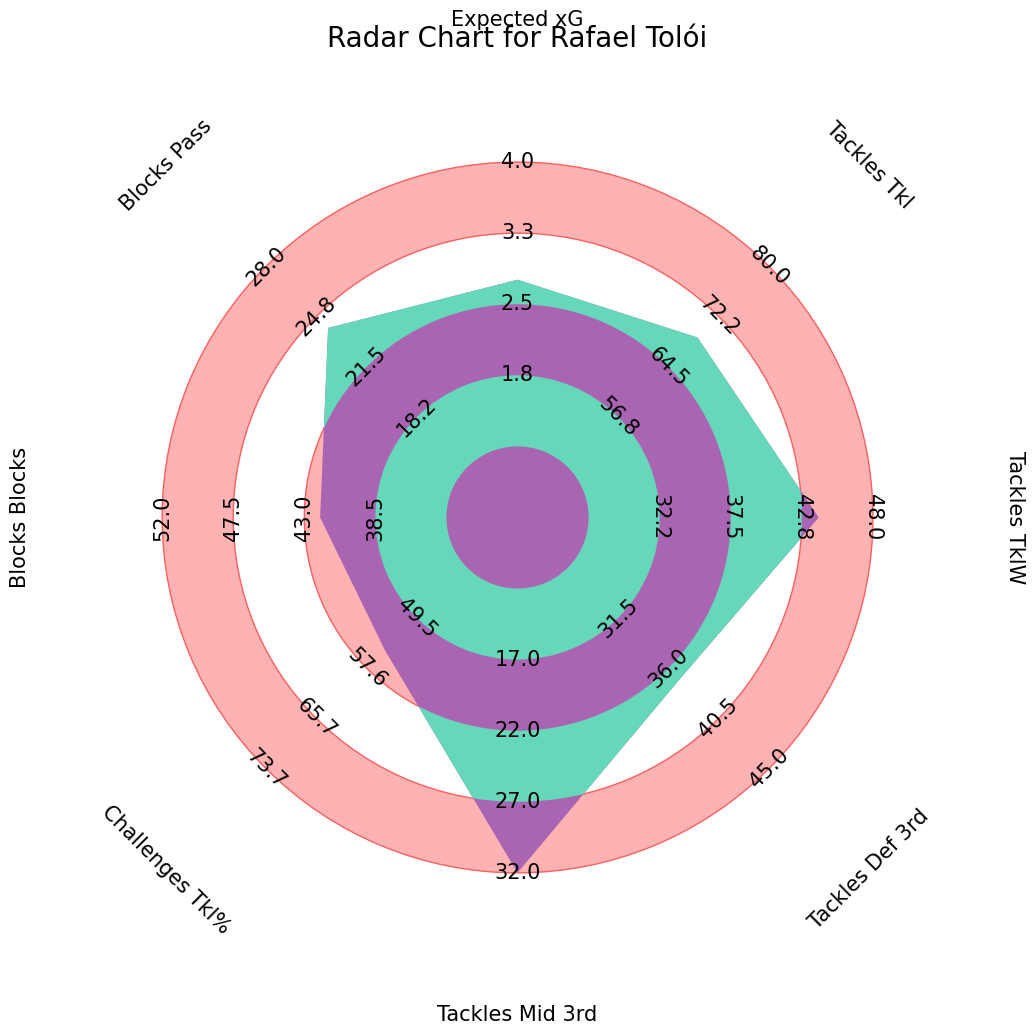

In [22]:
a = find_similar_players(4,df)
a

In [23]:
df

Rk            Player Nation    Pos               Squad  \
0        0  Brenden Aaronson    USA  MF,FW        Leeds United   
1        1   Paxten Aaronson    USA  MF,DF      Eint Frankfurt   
2        2    James Abankwah    IRL     DF             Udinese   
3        3     George Abbott    ENG     MF           Tottenham   
4        4  Yunis Abdelhamid    MAR     DF               Reims   
...    ...               ...    ...    ...                 ...   
2717  2717  Martín Zubimendi    ESP     MF       Real Sociedad   
2718  2718  Szymon Żurkowski    POL     MF  Fiorentina, Spezia   
2719  2719   Martin Ødegaard    NOR     MF             Arsenal   
2720  2720       Milan Đurić    BIH     FW       Hellas Verona   
2721  2721     Filip Đuričić    SRB  MF,FW           Sampdoria   

                Comp  Age  Born  Playing Time MP  Performance Gls  ...  \
0     Premier League   23  2000               36                1  ...   
1         Bundesliga   20  2003                7                0  ...   
2            Serie A   19  2004                2                0  ...   
3     Premier League   18  2005                1                0  ...   
4            Ligue 1   36  1987               37                1  ...   
...              ...  ...   ...              ...              ...  ...   
2717         La Liga   24  1999               36                1  ...   
2718         Serie A   26  1997               12                0  ...   
2719  Premier League   25  1998               37               15  ...   
2720         Serie A   33  1990               28                1  ...   
2721         Serie A   31  1992               32                3  ...   

      Total Att  Total Cmp%  Total TotDist  Total PrgDist  KP  1/3  PPA  \
0           797        74.3           7577           2182  46   47   16   
1            71        71.8            659            109   1    3    0   
2            29        79.3            375             79   0    0    0   
3             1       100.0              8              0   0    0    0   
4          2031        82.7          32967          13407  13  155    5   
...         ...         ...            ...            ...  ..  ...  ...   
2717       1812        85.3          26783           8092  20  175   23   
2718        120       158.8           1282            294   1   10    2   
2719       1804        80.3          22540           6014  76  135   91   
2720        523        51.2           3119            740  21   27    5   
2721        758        77.3           9599           2169  34   50   18   

      CrsPA  PrgP  Cluster  
0         4    86        0  
1         0     6        2  
2         0     0        2  
3         0     0        2  
4         0   215        1  
...     ...   ...      ...  
2717      1   184        1  
2718      0    11        2  
2719      4   266        0  
2720      0    29        2  
2721      4    77        0  

[2722 rows x 70 columns]